<a href="https://colab.research.google.com/github/Wuj94/Pansharpening/blob/master/NNDS_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks for Data Science Applications (2019/2020)
## Final exam (template)

* **Student(s)**: Giuseppe Calabrese (1852590).
* **Reference paper / topic**: W. Yao, Z. Zeng, C. Lian, H. Tang, 2019. Pixel-wise regression using U-Net and its application on pansharpening.



## Part 1: Report
Pansharpening addresses **the problem** of upgrading and integrating a low spatial resolution multispectral image with a high-spatial-resolution panchromatic image to produce a new multispectral image with high spatial resolution. [2]

The pansharpening method under development to combine these two types of images can effectively obtain high-spatial and high-spectral resolution images.

**The rationale** behind the use of neural networks to tackle the problem is clear once the bandwith ranges of the two sensed image are understood to be diffent. In the best case scenario, the two are perfectly overlapping. 
However, this is rarely the case in reality. 
For instance, for WorldView-3, the bandwidth range of the panchromatic channels is 450-800 nm, while that of multispectral channels covers 400–1040 nm. As a consequence, an highly non-linear mapping is needed to model a reliable spatial upgrade, given the difference in the bandwidth ranges. [1]

**The learning process** is carried out in a supervised fashion, even though the ground truth is not available. 

The mapping is obtained processing panchromatic images reduced in size, stacked to the correspondent multispectral images, supervised by the original corresponding multispectral images. This is done relying on the Wald protocol, which states that down-sampled remote sensing images are considered to be identical to the images that the corresponding sensor would observe at a lower resolution level. 
The loss function is the *mean squared error* function. [2]


**The dataset** is obtained using the World-View 3 sensor. The wavebands captured are grouped in 3 different images. We only consider the panchromatic and multispectral images. 

The panchromatic image has spatial resolution of 0.31m whereas the multispectral one has spatial resolution of 1.24m. 
This substantial difference is due to the tradeoff between spatial and spectral resolution, in the design of optical sensors. 

### References 
[1] Pansharpening by Convolutional Neural Networks.
G. Masi, D. Cozzolino, L. Verdoliva and G. Scarpa

[2] Pixel-wise regression using U-Net and its application on
pansharpening. 
Wei Yao, Zhigang Zeng, Cheng Lian, Huiming Tang

## Part 2: External libraries


In [1]:
!pip install rasterio # for raster image manipulation
!pip install matplotlib

%tensorflow_version 2.x

import rasterio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

TensorFlow 2.x selected.


## Part 3: Your code

In [0]:
def read_image(fp='dataset/6010_0_0_M.tif'):
  """Read a raster image"""
  src = rasterio.open(fp)
  return src.read()

def plot(cropped, title):
  """Plot a row of four multispectral images considering the first spectral band only"""
  n_row = 1
  n_col = 4
  fig, axis = plt.subplots(n_row, n_col, figsize=(10,3))
  fig.suptitle(title)
  fig.subplots_adjust(hspace=0.0, wspace=0.0)
  for idx, ax in enumerate(axis):
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.imshow(cropped[idx,:,:,0], cmap='pink')

def crop_image(image, batch_size=1, num_boxes=16, image_height=800,
               image_width=800, channels=8, crop_size=(200,200), output_size=(200,200)):
  """Crop and resize the given image."""
  def rearrange_axis(image):
    im = np.moveaxis(image, 0, 2)
    return np.expand_dims(im, axis=0)

  def crop(image, batch_size, num_boxes, image_height,
               image_width, channels, crop_size, output_size):
    boxes = [ [y_axis /image_height, 
               x_axis /image_width,
               (y_axis + crop_size[1])/image_height,
               (x_axis + crop_size[0])/image_width] 
             for y_axis in range(0, image_height, crop_size[1]) 
             for x_axis in range(0, image_width, crop_size[0]) ] 
    box_indices = np.zeros((num_boxes,),dtype=np.int32) # they're all 0s cause we're cropping a dataset with a single image (0-th)
    
    return tf.image.crop_and_resize(image, boxes, box_indices, output_size) # shape is (NUM_BOXES=16, WIDTH, HEIGHT, NUM_MS_BANDS=8)

  im = rearrange_axis(image)
  return crop(im, batch_size=batch_size, num_boxes=num_boxes, image_height=image_height,
               image_width=image_width, channels=channels, crop_size=crop_size, output_size=output_size)

from os import listdir

def read_filepath(directory="dataset"):
  """Read filenames that compose the dataset arranging the multispectral image 
  and the corresponding panchromatic image in the same tuple of the returned
  iterable."""
  result = []
  filepaths = list(map(lambda x : directory+"/"+x, sorted(listdir(directory))))
  for i in range(0, len(filepaths), 2):
    result.append((filepaths[i], filepaths[i+1]))
  return result

def build_dataset(file_list, out_size=(200,200), split=0.7):
  """Returns the training and the test dataset."""
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  
  n_train_imgs = int(len(file_list) * split)
  for i, fp in enumerate(file_list):
    ms_lr = crop_image(read_image(fp=fp[0]), output_size=out_size)
    pan_lr = crop_image(read_image(fp=fp[1]), output_size=out_size)
    staked_img = np.append(ms_lr.numpy(), pan_lr.numpy(), axis=3)
    if i <= n_train_imgs:
      x_train.append(staked_img)
    else:
      x_test.append(staked_img)

    if i <= n_train_imgs:
      y_train.append(ms_lr)
    else:
      y_test.append(ms_lr)
  return (x_train, y_train), (x_test, y_test)

def unet_model(m = 8, l1 = 200):
  """Construct the NN as described in the paper"""
  c1 = int(m / 2)
  c2 = int(c1 / 2)
  c3 = int(c2 * 2)
  c4 = int(c3 * 2)
  sub_factor = 2
  l2 = int(l1 / sub_factor)
  l3 = int(l2 / sub_factor)

  img_input = tf.keras.layers.Input(shape=(l1,l1,m+1))

  conv1 = tf.keras.layers.Conv2D(filters=c1, kernel_size=(3,3), activation="relu", padding="same")(img_input)
  pool1 = tf.keras.layers.AveragePooling2D(sub_factor, strides=2)(conv1)

  conv2 = tf.keras.layers.Conv2D(filters=c2, kernel_size=(3,3), activation="relu", padding="same")(pool1)
  pool2 = tf.keras.layers.AveragePooling2D(sub_factor, strides=2)(conv2)

  conv3 = tf.keras.layers.Conv2D(filters=c3, kernel_size=(3,3), activation="relu", padding="same")(pool2)

  up1 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(sub_factor)(conv3), conv2], axis=-1)
  conv4 = tf.keras.layers.Conv2D(filters=c4, kernel_size=(3,3), activation="relu", padding="same")(up1)

  up2 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(sub_factor)(conv4), conv1], axis=-1)
  o = tf.keras.layers.Conv2D(filters=m, kernel_size=(3,3), activation="relu", padding="same")(up2)
  
  model = tf.keras.Model(inputs=img_input, outputs=o, name='unet')
  return model

## Part 4 - Experimental evaluation


In [3]:
# mount Drive
from google.colab import drive
drive.mount('/content/drive')

# unzip the dataset
! mkdir dataset
! unzip "../content/drive/My Drive/dataset.zip" -d dataset
# The trailing letter represents:
# M for the multispectral image (small size)
# P for the panchromatic image (big size... 4 times larger)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘dataset’: File exists
Archive:  ../content/drive/My Drive/dataset.zip
replace dataset/6010_0_0_M.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/6010_0_0_M.tif  
  inflating: dataset/6010_0_0_P.tif  
  inflating: dataset/6010_0_1_M.tif  
  inflating: dataset/6010_0_1_P.tif  
  inflating: dataset/6010_0_2_M.tif  
  inflating: dataset/6010_0_2_P.tif  
  inflating: dataset/6010_0_3_M.tif  
  inflating: dataset/6010_0_3_P.tif  
  inflating: dataset/6010_0_4_M.tif  
  inflating: dataset/6010_0_4_P.tif  
  inflating: dataset/6010_1_0_M.tif  
  inflating: dataset/6010_1_0_P.tif  
  inflating: dataset/6010_1_1_M.tif  
  inflating: dataset/6010_1_1_P.tif  
  inflating: dataset/6010_1_2_M.tif  
  inflating: dataset/6010_1_2_P.tif  
  inflating: dataset/6010_1_3_M.tif  
  inflating: dataset/6010_1_3_P.tif  
  inflating: 

In [4]:
from functools import reduce

train_fp = read_filepath("dataset")
train_ds, test_ds = build_dataset(train_fp)

# Construct the X variable putting all the images in the same ndarray
ms_pan = reduce(lambda a,b: np.append(a, b, axis=0), train_ds[0])
# Construct the y variable putting all the images in the same ndarray
ms = reduce(lambda a,b: np.append(a, b, axis=0), train_ds[1])

ms_pan_test = reduce(lambda a,b: np.append(a, b, axis=0), test_ds[0]) # X test
ms_test = reduce(lambda a,b: np.append(a, b, axis=0), test_ds[1])  # y test

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [6]:
model = unet_model()
model.load_weights('../content/drive/My Drive/MyCNN/epochs:3273-val_loss:31.830.hdf5')
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=["mse"])
model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 9) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 200, 200, 4)  328         input_2[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_2 (AveragePoo (None, 100, 100, 4)  0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 100, 100, 2)  74          average_pooling2d_2[0][0]        
_______________________________________________________________________________________________

In [7]:
# Early stopping has been chosen as a simple way to avoid overfitting
# as the low number of parameter suggests (no need to dropout)
filepath="../content/drive/My Drive/MyCNN/epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min', restore_best_weights=True)

history = model.fit(x=ms_pan, y=ms, batch_size=128, epochs=8000, validation_split=0.2, callbacks=[es, checkpoint])

Streaming output truncated to the last 5000 lines.
217/217 [==============================] - 1s 2ms/sample - loss: 23.9260 - mse: 23.9260 - val_loss: 26.2058 - val_mse: 26.2058
Epoch 1133/8000
217/217 [==============================] - 1s 2ms/sample - loss: 24.1053 - mse: 24.1053 - val_loss: 26.0732 - val_mse: 26.0732
Epoch 1134/8000
217/217 [==============================] - 1s 2ms/sample - loss: 24.3038 - mse: 24.3038 - val_loss: 26.4038 - val_mse: 26.4038
Epoch 1135/8000
217/217 [==============================] - 1s 3ms/sample - loss: 24.6752 - mse: 24.6752 - val_loss: 26.6136 - val_mse: 26.6136
Epoch 1136/8000
217/217 [==============================] - 0s 2ms/sample - loss: 24.9176 - mse: 24.9176 - val_loss: 27.7455 - val_mse: 27.7455
Epoch 1137/8000
217/217 [==============================] - 0s 2ms/sample - loss: 26.2365 - mse: 26.2365 - val_loss: 30.0404 - val_mse: 30.0404
Epoch 1138/8000
217/217 [==============================] - 1s 2ms/sample - loss: 28.7348 - mse: 28.7348 - v

In [8]:
# The model's performance are evaluated
model.evaluate(x=ms_pan_test, y=ms_test)

96/96 [==============================] - 0s 5ms/sample - loss: 18.8620 - mse: 18.8620


[18.86203734079997, 18.862038]

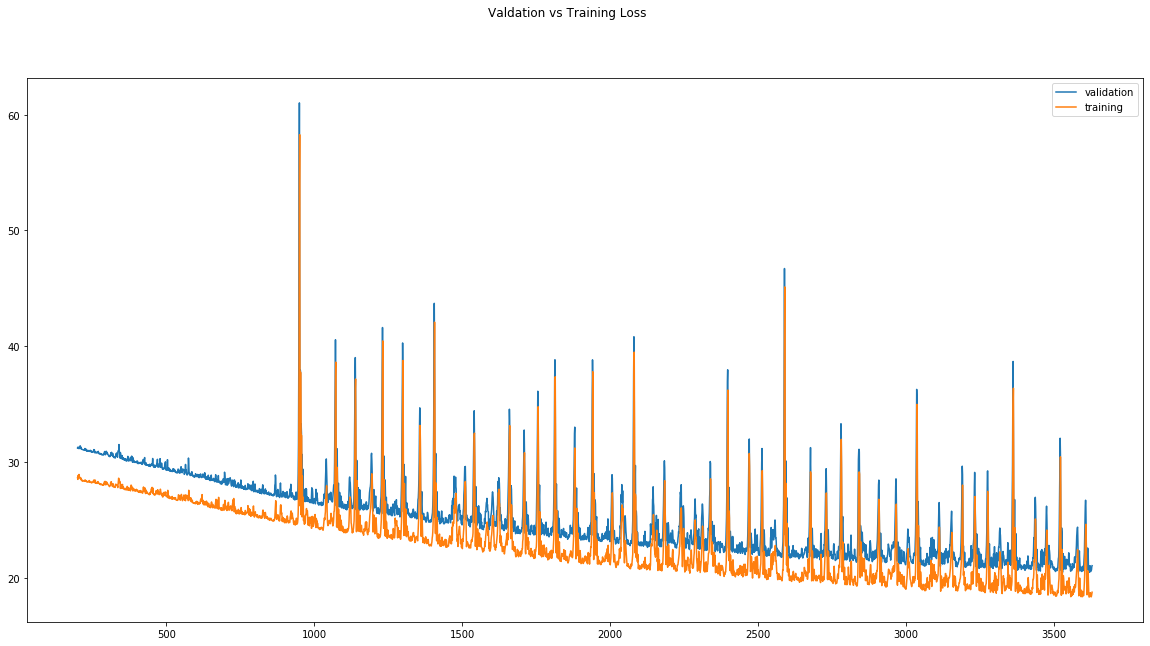

In [9]:
# This plot shows the training process to investigate the noise due to the 
# stochastic nature of SGD.
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.plot(history.epoch[200:], history.history['val_loss'][200:], label='validation')
ax.plot(history.epoch[200:], history.history['loss'][200:], label='training')
fig.suptitle("Valdation vs Training Loss")
ax.legend(loc='upper right')

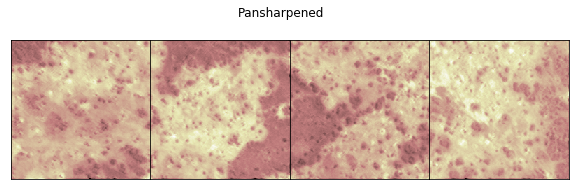

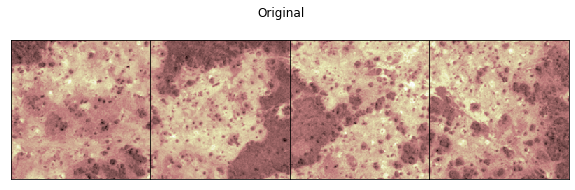

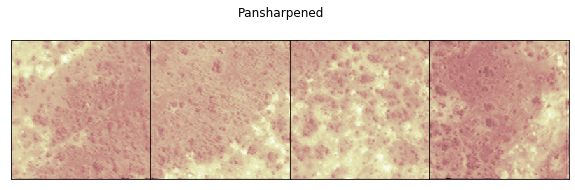

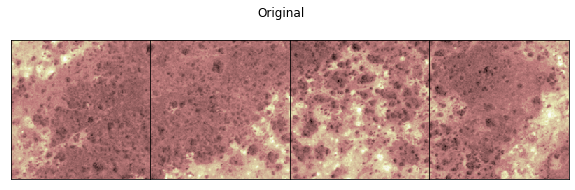

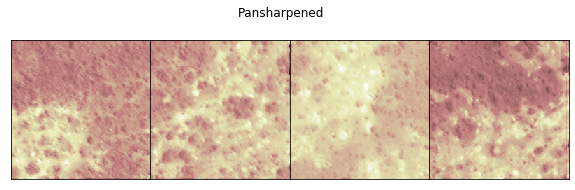

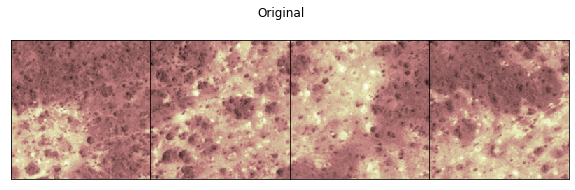

In [10]:
# Here some images are show to compare the results with the ground truth.
y_hat = model.predict(x=ms_pan_test)

plot(y_hat[:8, :, :,:], title='Pansharpened')
plot(ms_test[:8, :, :,:], title='Original')

plot(y_hat[40:48, :, :,:], title='Pansharpened')
plot(ms_test[40:48, :, :,:], title='Original')

plot(y_hat[32:40, :, :,:], title='Pansharpened')
plot(ms_test[32:40, :, :,:], title='Original')